# This section uses Magpie to calculate surface brightness profile

This is equivalently what the previous section does, but magpie is used to calculate surface brightness profile for each Ha Hb line maps and weights, averaged out over the polar angle phi, for each given pixel distance.

what does the package [magpie](https://github.com/knaidoo29/magpie/tree/master) do:

It transforms grid in Cartesian coordinates into (r,phi) polar coordinates, while preserving the size of the surface area of each pixel. Therefore one can calculate surface brightness of a certain ring area by summing over phi of a given radius range. This method is used in [Matharu 2023](https://iopscience.iop.org/article/10.3847/2041-8213/acd1db/pdf) and [Matharu 2024](https://arxiv.org/pdf/2404.17629).

Update: Now this script also calculates dust attenuation assuming [Calzetti et al. (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...533..682C/abstract)

In [1]:
import  magpie              as     magpie

### calculate radial profile

In [1]:
import  numpy               as     np
from    scripts.tools       import *
from    astropy.table       import Table
from    astropy.io          import fits
from    astropy.cosmology   import Planck18
import  astropy.units       as     u
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
from    matplotlib          import use
from    tqdm                import tqdm
from    concurrent.futures  import ThreadPoolExecutor, as_completed
import  sys, os
from    IPython.display     import clear_output
from    astropy.wcs         import WCS

obj_lis = Table.read('obj_lis_selected.fits')


In [2]:
def K_lambda(line='Ha'):
    #calzetti_attenuation
    """
    Calculate the dust attenuation value k(lambda) from the Calzetti et al. (2000) attenuation curve.
    Parameters:
        wavelength_nm (float): Wavelength in nanometers (nm).
    """
    wavelength_um =  (0.6563 if line == 'Ha' else 0.4861)
    if 0.12 <= wavelength_um <= 0.63:
        # Formula for the UV to optical wavelength range
        k_lambda = 2.659 * (-1.857 + 1.040 / wavelength_um) + 4.05
    elif wavelength_um > 0.63:
        # Formula for the near-infrared wavelength range
        k_lambda = 2.659 * (-2.156 + 1.509 / wavelength_um - 0.198 / (wavelength_um ** 2) + 0.011 / (wavelength_um ** 3)) + 4.05
    return k_lambda


import magpie.montecarlo
#use the montecarlo module to remap the data to polar coordinates
def spatial_remap(map,pixel_length,r_bins=50):
    b2r = magpie.montecarlo.Box2Ring()
    b2r.setup_box(-24.5*pixel_length, 24.5*pixel_length, 50,
                  -24.5*pixel_length, 24.5*pixel_length, 50)
    b2r.setup_polar_lin(0., 24.5*pixel_length, r_bins, 4, center=[0., 0.])
    b2r.get_weights() 
    return np.linspace(b2r.redges[0], b2r.redges[-1],r_bins), b2r.remap(map)


#this function will return the radial profile of a given object
#function: calls the magpie function spatial_remap to remap the data to polar coordinates
def radial_profile(obj,linemap,weight,seg,pixel_length):
        linemap = linemap.data; weight = weight.data
        #convert the seg map to a binary map, for further conversion to weight map
        seg = np.where(seg==obj['ID'],1,0)
        seg = spatial_remap(seg,pixel_length)[1]
        seg_weight = seg/np.sum(seg,axis=0)

        r, linemap_r,   = spatial_remap(np.where(linemap>0,linemap,0),pixel_length)
        linemap_r_wht = spatial_remap(np.where(linemap>0,weight,0),pixel_length)[1]


        map_r   = np.average(linemap_r,weights=seg_weight,axis=0)
        map_r_err = 1/np.sum(linemap_r_wht*seg,axis=0)**0.5
        map_r_std = np.average((linemap_r-map_r)**2,weights = seg_weight,axis=0)**0.5
        map_r_err = (map_r_err**2 + map_r_std**2)**0.5
        return r, map_r, map_r_err 

#this function will generate the             print(r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err)
#radial table for a given object
def gen_radial_table(obj,
                     LINE_HA='LINE_HA',      LINE_HB='LINE_HB_CONV',
                     LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    #try:
    path = f"data_extracted/{file_name(obj,prefix='extracted')}"
    with fits.open(path,mode='update') as hdu:
        if find_data('SEG_MOD',hdu) != None:
            seg_map = find_data('SEG_MOD',hdu)[1].data
        else:
            seg_map = find_data('SEG',hdu)[1].data

        #extract the radial profile surface brightness
        r, ha_r, ha_r_err = radial_profile(obj,
                                        linemap      = find_data(LINE_HA,hdu)[1],
                                        weight       = find_data(LINEWHT_HA,hdu)[1],
                                        seg          = seg_map,
                                        pixel_length = obj['pixel_length'])
        
        r, hb_r, hb_r_err = radial_profile(obj,
                                        linemap      = find_data(LINE_HB,hdu)[1],
                                        weight       = find_data(LINEWHT_HB,hdu)[1],
                                        seg          = seg_map,
                                        pixel_length = obj['pixel_length'])

        #calculate the balmer decrement
        balmer_r     = ha_r/hb_r
        balmer_r_err = ((ha_r_err/hb_r)**2 + (hb_r_err**2 * (ha_r/hb_r**2)**2))**0.5
        
        #now calculate the extinction
        #color excess
        E_ba = 2.5*np.log10(balmer_r/2.86)
        #attenutation
        A_ba = E_ba/(K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')

        #columns for the radial table
        cols = [
            fits.Column(name='DISTANCE [kpc]',                       format='E', array=r),
            fits.Column(name='Ha_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=ha_r),
            fits.Column(name='Ha_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=ha_r_err),
            fits.Column(name='Hb_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=hb_r),
            fits.Column(name='Hb_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=hb_r_err),
            fits.Column(name='BALMER_DECREM',                        format='E', array=balmer_r),
            fits.Column(name='BALMER_DECREM_ERR',                    format='E',array=balmer_r_err),
            fits.Column(name='E_BV',                                  format='E', array=E_ba),
            fits.Column(name='A_Ha',                                  format='E', array=A_ba)
        ]
        
        #choose the right name for saving the radial table
        if 'CONV' in LINE_HB:
            name_addon = '_CONV'
        else:
            name_addon = ''
        if 'BG' not in LINE_HA:
            name = f'RAD_PROFILE{name_addon}'
            new_table = fits.BinTableHDU.from_columns(cols, name=name)
        else:
            name = f'RAD_PROFILE{name_addon}_BG'
            new_table = fits.BinTableHDU.from_columns(cols, name=name)

        #save or update table
        save_update(new_table,hdu)
        hdu.flush()
        return f"{obj['subfield']}-{obj['ID']} processed"
    #except Exception as e:
    #        return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"

def cat_process(obj_lis,
                LINE_HA,   LINE_HB,
                LINEWHT_HA, LINEWHT_HB,
                max_threads=1):
        print(f'start process,{LINE_HA},{LINE_HB}')
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    gen_radial_table,
                    obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB
                                            ): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(gen_radial_table(obj,LINE_HA,LINE_HB,LINEWHT_HA,LINEWHT_HB))
            return results


def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    
    results1 = cat_process(obj_lis,
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=1)
    errorcounting(results1)

    results3 = cat_process(obj_lis,
                        LINE_HA='LINE_HA',LINE_HB='LINE_HB_CONV',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=1)
    errorcounting(results3)

'''
    results2 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB',max_threads=6)
    errorcounting(results2)
    
    results4 = cat_process(obj_lis,
                        LINE_HA='LINE_HA_BG',LINE_HB='LINE_HB_CONV_BG',
                        LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV',max_threads=6)
    errorcounting(results4)
'''
if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'magpie'

### plot radial profiles

In [8]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from matplotlib import colors
from matplotlib.pyplot import cm
from matplotlib import use
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from scripts.tools import *


def plot_balmer_decrem(obj, plot, plot_var, crop_size=50):
    try:
        # Construct the path to the FITS file
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        
        # Open the FITS file
        with fits.open(path) as hdu:
            # Determine the center of the image
            shape = hdu[3].data.shape[0]
            si = (shape - crop_size) // 2; 
            ei = si + crop_size

            #extract segmentation map
            if find_data('SEG_MOD',hdu) != None:
                seg = find_data('SEG_MOD',hdu)[1].data
            else:
                seg = find_data('SEG',hdu)[1].data

            #effective radius (in arcsec)
            r_eff = obj['re']
             
            # Create a figure with subplots
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()

            # Loop through the specified image names and plot them
            #here i try to add segmentation map effect to the image
            for i, name in enumerate(['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']):
                if name == '2D_BALMER':
                    norm = colors.Normalize(vmin=0, vmax=10)
                    image = fits.ImageHDU(data = find_data('LINE_HA', hdu)[1].data/find_data('LINE_HB_CONV', hdu)[1].data)
                else:
                    image = find_data(name, hdu)[1]
                titles = {
                        "DSCI": 'direct imaging',
                        "LINE_HA": r"H$\alpha$",
                        "LINE_HB_CONV": r"H$\beta$",
                        "2D_BALMER": r'$H\alpha / H\beta$'
                        }
                data = image.data[si:ei, si:ei]
                # Extract the segmentation map for the same region
                seg_crop = seg[si:ei, si:ei]
                # Create a mask where the segmentation map matches the object ID
                mask = seg_crop == obj['ID']
                
                ax = axes[i]
                ax.tick_params(direction='in',which='both', top=True, right=True)

                # Plot the original data with plasma_r colormap
                norm = colors.LogNorm()#vmin=np.nanmin(data),vmax = np.nanmax(data))
                #if name == '2D_BALMER':
                #    norm = colors.Normalize(vmin=0, vmax=10)
                im = ax.imshow(np.where(mask,data,np.nan), norm=norm, origin='lower', cmap='plasma_r')
                
                # Convert the colormap to grayscale
                cmap = cm.get_cmap('plasma_r')
                cmap_colors = cmap(np.arange(cmap.N))
                hsv_colors = rgb_to_hsv(cmap_colors[:, :3])
                hsv_colors[:, 1] = 0  # Set saturation to 0 to convert to grayscale
                gray_cmap = colors.ListedColormap(hsv_to_rgb(hsv_colors))

                # Overlay the segmentation map with gray colormap and lower transparency
                ax.imshow(np.where(np.logical_not(mask),data,np.nan), norm=norm, origin='lower', cmap=gray_cmap, alpha=0.5)
                
                # Plot a circle representing the effective radius
                circ = plt.Circle((crop_size/2-1, crop_size/2-1), r_eff / 0.1, color='blue', fill=False, linestyle='--',label='effective radius',linewidth=2)
                ax.add_patch(circ)

                ax.plot([3, 7], [4, 4])
                ax.text(5, 5, f"{round(obj['pixel_length'] * 4, 2)} kpc")
                ax.set_ylabel(f'{titles[name]}')
                ax.set_xticklabels([]);ax.set_yticklabels([])
                ax.legend()

            # Extract and plot the radial profiles
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data(plot, hdu)[1].data).transpose()

            if True:
                # Plot the Ha and Hb radial profiles
                ax = plt.subplot2grid((2, 4), (1, 0), colspan=2)
                ax.errorbar(r, ha_r, yerr=ha_r_err, fmt='ro:', label=r'H$\alpha$', alpha=0.5)
                ax.errorbar(r, hb_r, yerr=hb_r_err, fmt='go:', label=r'H$\beta$', alpha=0.5)

                # Effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                
                # Determine the plot limits
                arr = np.array((ha_r, hb_r))
                arr = arr[arr > 0]
                plot_min = np.nanmin(arr) * 0.05
                plot_max = np.nanmax(arr) * 100

                # Annotate the effective radius
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min * 2),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min * 2),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min * 2.1, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')
                ax.set_xlabel('r [kpc]')
                ax.set_ylabel('flux [$10^{-17}$ erg/s/cm$^2$]')
                ax.set_ylim(plot_min, plot_max)
                ax.set_yscale('log')
                #ax.tick_params(direction='in', which='both', top=True, right=True)
                ax.legend()

                # Adjust y-axis tick labels to avoid overlap
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0e}'.format(y)))

            if True:
                # Plot the Balmer decrement radial profile
                #make xticks no overlap
                ax = plt.subplot2grid((2, 4), (1, 2), colspan=2)
                mask = np.logical_and(np.logical_not(np.isnan(balmer_r)),balmer_r>0)
                ax.set_xlabel('distance [kpc]')
                ax.set_ylabel(r'$H\alpha / H\beta$')
                ax.set_ylim(-5, 15)
                # Annotate the effective radius
                plot_min = -4.5
                #effective radius
                ax.axvspan(0, r_eff * obj['pixel_length'] / 0.1, color='grey', alpha=0.3)
                ax.annotate(
                    "",  # Only draw the arrow, no text
                    xy=(0, plot_min),  # Right endpoint
                    xytext=(r_eff * obj['pixel_length'] / 0.1, plot_min),  # Left endpoint
                    arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"),  # Horizontal double arrow
                )
                ax.text(r_eff * obj['pixel_length'] / 0.1 / 2, plot_min, 
                        r"$r_{eff}$", fontsize=12, color="black", ha="center",va='bottom')

                # Plot the A_Ha radial profile on a secondary y-axis
                ax2 = ax.twinx()
                l2 = ax2.errorbar(r[mask], A_Ha[mask], yerr=balmer_r_err[mask], color='darkblue', linestyle='-', fmt='o', label=r'Attenuation H$\alpha$', alpha=0.5)
                ax2.set_ylabel(r'$A_{H\alpha}$')
                ax2.set_ylim(-5,5)

                # Combine legends
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines + lines2, labels + labels2, loc='upper left')

                ax.tick_params(direction='in',which='both', top=True, right=False)
                ax2.tick_params(direction='in',right=True)

            # Add a big title for the entire figure
            fig.suptitle(f"{obj['subfield']}- {obj['ID']}, Mass: {round(np.log10(obj['mass']),2)}[log$M_\odot$], Redshift: {round(obj['z_MAP'],2)}, $r_e: {round(r_eff/0.1)} [kpc]$", fontsize=16)

            # Save the plot
            save_path = f"radial_balmer_decrem/{plot}_vs_{plot_var}"
            save_path_sn_10 = f"sn_10/radial_balmer_decrem/{plot}_vs_{plot_var}"
            os.makedirs(save_path, exist_ok=True)
            os.makedirs(save_path_sn_10, exist_ok=True)
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the big title

            if obj['sn_hb'] > 10:
                plt.savefig(f"{save_path_sn_10}/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png",dpi=300)
            if obj['manual_select'] == 'keep':
                plt.savefig(f"{save_path}/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png")
            else:
                plt.savefig(f"{save_path}/selected/{obj['subfield']}-{obj['ID']}_{obj['tag']}_{obj['manual_select']}.png")

                
           #plt.close('all')
            clear_output(wait=True)
            return f"{obj['subfield']}-{obj['ID']} saved"
    except Exception as e:
            print(f"! {obj['subfield']}-{obj['ID']} failed, error{e}")
            return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"


def cat_process(obj_lis, plot='RAD_PROFILE_ELLIP__CONV_PACK', plot_var='RAD_PROFILE_BG', max_threads=1):
    print(f'\n start plot process{plot,plot_var}')
    results = []
    if max_threads > 1:
        # Use multithreading to process the objects in parallel
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(plot_balmer_decrem, obj, plot=plot, plot_var=plot_var): obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        # Process the objects sequentially
        for obj in tqdm(obj_lis):
            results.append(plot_balmer_decrem(obj, plot, plot_var))
        return results

def main():
    use('Agg')  # Use the 'Agg' backend for matplotlib
    obj_lis = Table.read('obj_lis_selected_removed.fits')#[:2] # Read the object list from a FITS file
    
    # Process the objects and plot the results
    results1 = cat_process(obj_lis, plot='RAD_PROFILE_ELLIP__CONV_PACK', plot_var='RAD_PROFILE_CONV', max_threads=1)
    errorcounting(results1)
    print(results1)

if __name__ == '__main__':
    main()


 95%|█████████▌| 900/943 [08:49<00:21,  2.04it/s]/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_31849/4162948886.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma_r')
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_31849/4162948886.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma_r')
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_31849/4162948886.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or `

KeyboardInterrupt: 


 start plot process('RAD_PROFILE', 'RAD_PROFILE_CONV')


/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_36188/1857382127.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma_r')
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_36188/1857382127.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma_r')
/var/folders/6h/pm731bh5769gqlt1mrys7wth0000gn/T/ipykernel_36188/1857382127.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cma

total number of obj processed: 2
number of failed obj 0
['GN2-10512 saved', 'GN2-11228 saved']


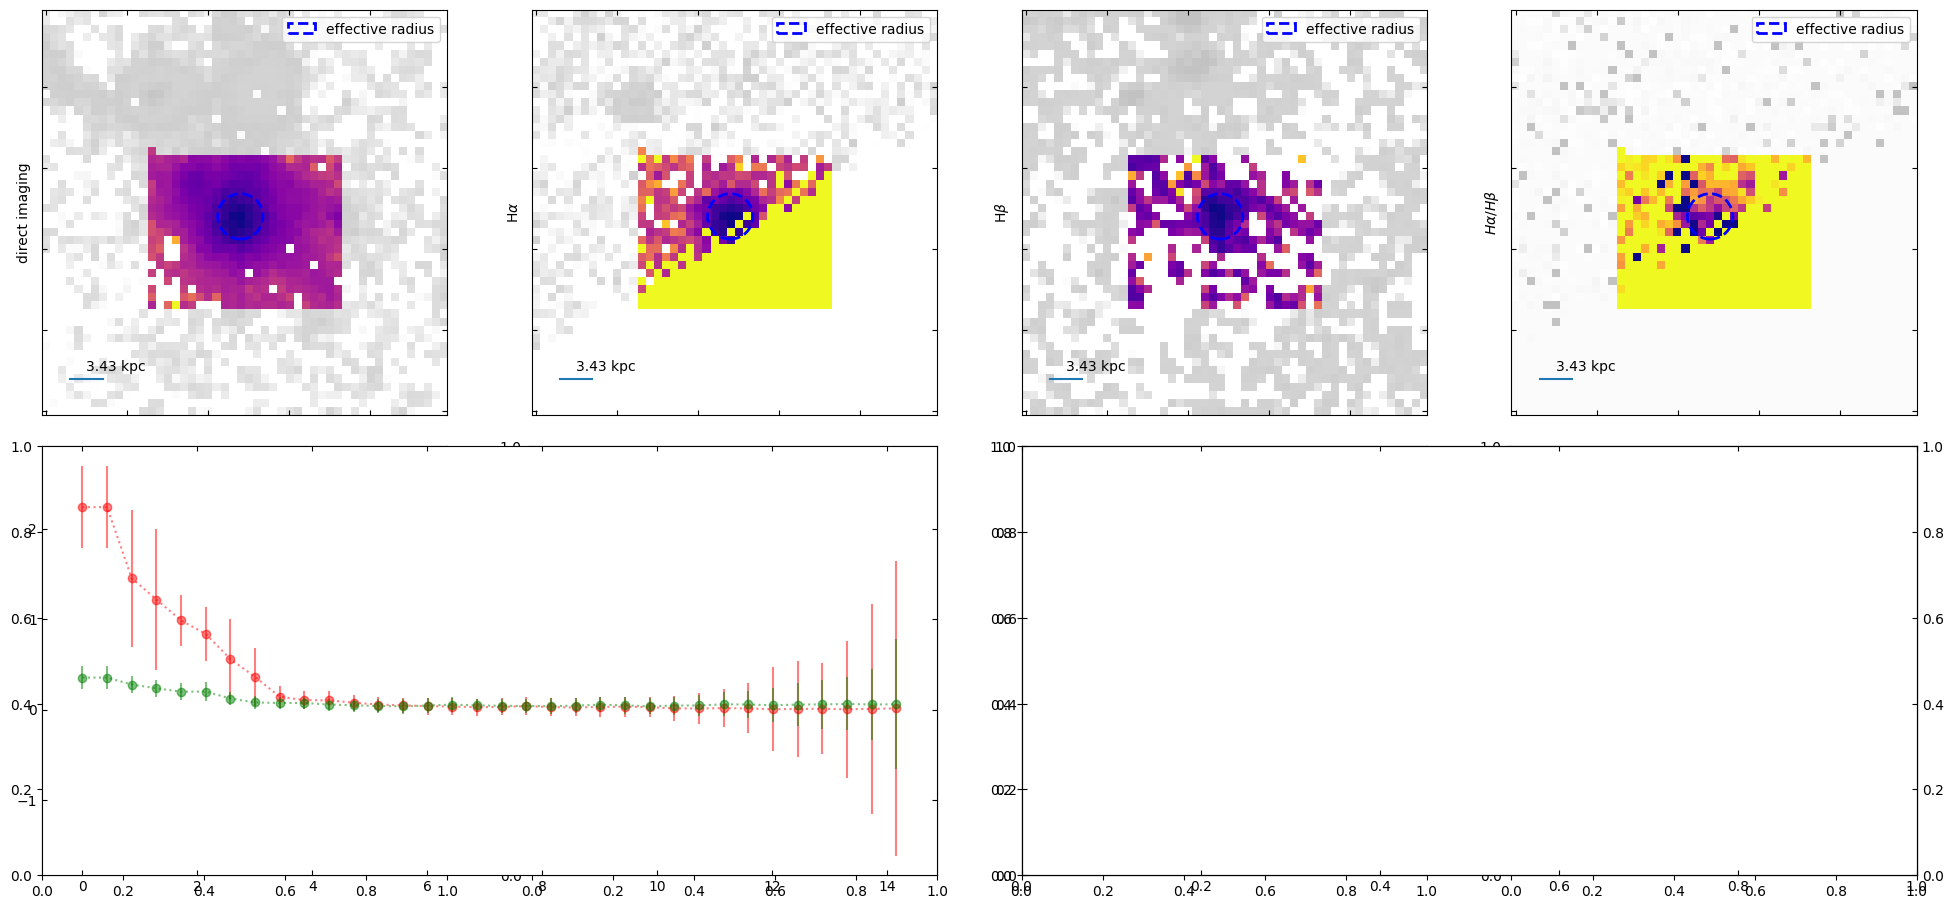

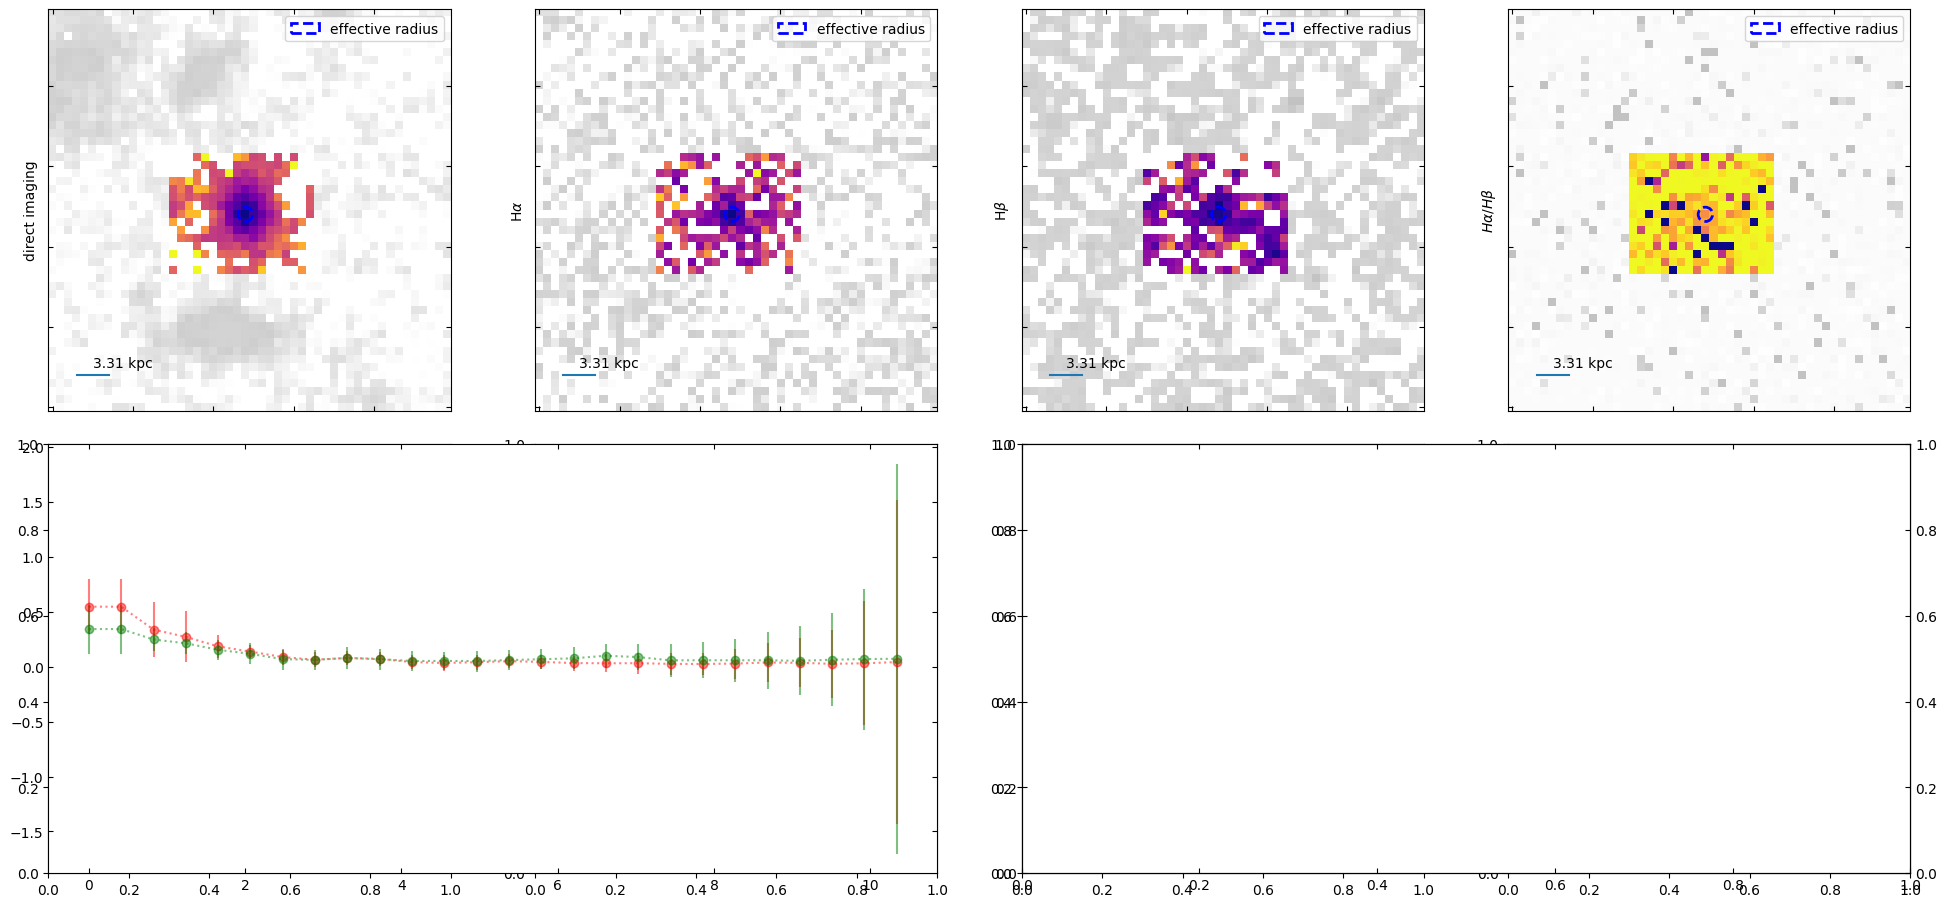

In [15]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from matplotlib import colors
from matplotlib.pyplot import cm
from matplotlib import use
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from scripts.tools import *


def plot_balmer_decrem(obj, plot, plot_var, crop_size=50):
    try:
        # 构造文件路径
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        
        # 打开FITS文件
        with fits.open(path) as hdu:
            # 确定图像中心
            shape = hdu[3].data.shape[0]
            si = (shape - crop_size) // 2 
            ei = si + crop_size

            # 提取分割图
            seg = find_data('SEG_MOD',hdu)[1].data if find_data('SEG_MOD',hdu) else find_data('SEG',hdu)[1].data

            # 有效半径（角秒）
            r_eff = obj['re']
             
            # 创建子图画布
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()

            # 绘制前4个子图
            for i, name in enumerate(['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']):
                # ... [保持原有代码不变] ...
                image = find_data(name, hdu)[1]
                titles = {
                        "DSCI": 'direct imaging',
                        "LINE_HA": r"H$\alpha$",
                        "LINE_HB_CONV": r"H$\beta$",
                        "2D_BALMER": r'$H\alpha / H\beta$'
                        }
                data = image.data[si:ei, si:ei]
                # Extract the segmentation map for the same region
                seg_crop = seg[si:ei, si:ei]
                # Create a mask where the segmentation map matches the object ID
                mask = seg_crop == obj['ID']
                
                ax = axes[i]
                ax.tick_params(direction='in',which='both', top=True, right=True)

                # Plot the original data with plasma_r colormap
                norm = colors.LogNorm()#vmin=np.nanmin(data),vmax = np.nanmax(data))
                if name == '2D_BALMER':
                    norm = colors.Normalize(vmin=0, vmax=10)
                im = ax.imshow(np.where(mask,data,np.nan), norm=norm, origin='lower', cmap='plasma_r')
                
                # Convert the colormap to grayscale
                cmap = cm.get_cmap('plasma_r')
                cmap_colors = cmap(np.arange(cmap.N))
                hsv_colors = rgb_to_hsv(cmap_colors[:, :3])
                hsv_colors[:, 1] = 0  # Set saturation to 0 to convert to grayscale
                gray_cmap = colors.ListedColormap(hsv_to_rgb(hsv_colors))

                # Overlay the segmentation map with gray colormap and lower transparency
                ax.imshow(np.where(np.logical_not(mask),data,np.nan), norm=norm, origin='lower', cmap=gray_cmap, alpha=0.5)
                
                # Plot a circle representing the effective radius
                circ = plt.Circle((crop_size/2-1, crop_size/2-1), r_eff / 0.1, color='blue', fill=False, linestyle='--',label='effective radius',linewidth=2)
                ax.add_patch(circ)

                ax.plot([3, 7], [4, 4])
                ax.text(5, 5, f"{round(obj['pixel_length'] * 4, 2)} kpc")
                ax.set_ylabel(f'{titles[name]}')
                ax.set_xticklabels([]);ax.set_yticklabels([])
                ax.legend()

            # Extract and plot the radial profiles
            r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data(plot, hdu)[1].data).transpose()
            # ========== 修改部分开始 ==========
            # 绘制径向分布图（左下）
            ax = plt.subplot2grid((2, 4), (1, 0), colspan=2)
            ax.errorbar(r, ha_r, yerr=ha_r_err, fmt='ro:', label=r'H$\alpha$', alpha=0.5)
            ax.errorbar(r, hb_r, yerr=hb_r_err, fmt='go:', label=r'H$\beta$', alpha=0.5)

            # 设置刻度参数
            ax.tick_params(
                direction='in',
                which='both',
                top=True,       # 显示顶部刻度线
                right=True,      # 显示右侧刻度线
                labeltop=False,  # 关闭顶部标签
                labelright=False # 关闭右侧标签
            )
            
            # ... [其余注释和设置保持不变] ...

            # 绘制Balmer减幅图（右下）
            ax = plt.subplot2grid((2, 4), (1, 2), colspan=2)
            mask = np.logical_and(np.logical_not(np.isnan(balmer_r)), balmer_r>0)
            
            # 设置主坐标轴刻度
            ax.tick_params(
                direction='in',
                which='both',
                top=True,        # 显示顶部刻度线
                labeltop=False   # 关闭顶部标签
            )
            
            # 设置右侧副坐标轴
            ax2 = ax.twinx()
            ax2.tick_params(
                direction='in',
                right=True,       # 显示右侧刻度线
                labelright=True   # 显示右侧标签
            )
            # ========== 修改部分结束 ==========

            # ... [保持其余代码不变] ...

            # 保存图像
            save_path = f"radial_balmer_decrem/{plot}_vs_{plot_var}"
            os.makedirs(save_path, exist_ok=True)
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            plt.savefig(f"{save_path}/{obj['subfield']}-{obj['ID']}.png", dpi=300)
            #plt.close()

            return f"{obj['subfield']}-{obj['ID']} saved"
    except Exception as e:
            print(f"! {obj['subfield']}-{obj['ID']} failed, error{e}")
            return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"

# ... [保持cat_process和main函数不变] ...
def cat_process(obj_lis, plot='RA D_PROFILE', plot_var='RAD_PROFILE_BG', max_threads=1):
    print(f'\n start plot process{plot,plot_var}')
    results = []
    if max_threads > 1:
        # Use multithreading to process the objects in parallel
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(plot_balmer_decrem, obj, plot=plot, plot_var=plot_var): obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        # Process the objects sequentially
        for obj in tqdm(obj_lis):
            results.append(plot_balmer_decrem(obj, plot, plot_var))
        return results

def main():
    #use('Agg')  # Use the 'Agg' backend for matplotlib
    obj_lis = Table.read('obj_lis_selected.fits')[:2] # Read the object list from a FITS file
    
    # Process the objects and plot the results
    results1 = cat_process(obj_lis, plot='RAD_PROFILE', plot_var='RAD_PROFILE_CONV', max_threads=1)
    errorcounting(results1)
    print(results1)

if __name__ == '__main__':
    main()
